In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score

2025-08-24 15:26:51.174013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 15:26:51.174096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 15:26:51.176706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-24 15:26:51.192369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 15:26:52.240246: W tensorflow/compiler/tf2

In [2]:
def get_trend_changes_report_dict(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4,
        output_dict=True,
        zero_division=0
    )

def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

In [3]:
train_set = pd.read_csv("../../../data/post_cleaning/training_set.csv")
validation_set = pd.read_csv("../../../data/post_cleaning/validation_set.csv")
test_set = pd.read_csv("../../../data/post_cleaning/test_set.csv")
final_data = pd.read_csv("../../../data/post_cleaning/final_data.csv")

In [7]:
y_val = validation_set['target_trend']
y_val_pred = validation_set['trend_d0']

In [8]:
report = classification_report(y_val, y_val_pred, digits=4)
print(f"NaiveModel report:\n {report}")
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))

NaiveModel report:
               precision    recall  f1-score   support

          -1     0.9140    0.9043    0.9091        94
           0     0.6098    0.6098    0.6098        41
           1     0.9375    0.9434    0.9404       159

    accuracy                         0.8844       294
   macro avg     0.8204    0.8191    0.8198       294
weighted avg     0.8843    0.8844    0.8843       294

Balanced accuracy: 0.8191358810416688


In [9]:
print(trend_changes_score(y_val, y_val_pred))

              precision    recall  f1-score   support

       False     0.8996    0.8996    0.8996       259
        True     0.2353    0.2353    0.2353        34

    accuracy                         0.8225       293
   macro avg     0.5675    0.5675    0.5675       293
weighted avg     0.8225    0.8225    0.8225       293



In [10]:
# --- Exportar y Comparar Métricas de Modelos (Validación) ---

# 1. Definir el nombre del modelo actual y el archivo de salida
model_name = 'Naive Model'
output_file = '../../../score_models/model_comparison_metrics.csv'

# 2. Calcular el reporte de clasificación estándar
# Usamos y_val_m y y_val_pred que están en la misma escala (0,1,2)
report_dict = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
precision = report_dict['macro avg']['precision']
recall = report_dict['macro avg']['recall']
f1_score = report_dict['macro avg']['f1-score']


# 3. Calcular el reporte de cambio de tendencia
report = get_trend_changes_report_dict(y_val, y_val_pred)
trend_change_precision = report['True']['precision']
trend_change_recall = report['True']['recall']
trend_change_f1_score = report['True']['f1-score']

# 4. Organizar las nuevas métricas
new_metrics = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'trend_change_precision': trend_change_precision,
    'trend_change_recall': trend_change_recall,
    'trend_change_f1_score': trend_change_f1_score
}

# 5. Cargar, actualizar y guardar el DataFrame de comparación
try:
    # Intentar cargar el archivo existente
    comparison_df = pd.read_csv(output_file, index_col='model')
    # Si existe, actualizar o añadir la fila para el modelo actual
    comparison_df.loc[model_name] = new_metrics
except FileNotFoundError:
    # Si no existe, crear un DataFrame nuevo directamente con los datos actuales
    comparison_df = pd.DataFrame([new_metrics], index=[model_name])

# Guardar el DataFrame actualizado en el CSV
comparison_df.to_csv(output_file, index_label='model')

--- Resultados del Backtesting ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $12,896.32
Retorno Total de la Estrategia: 28.96%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


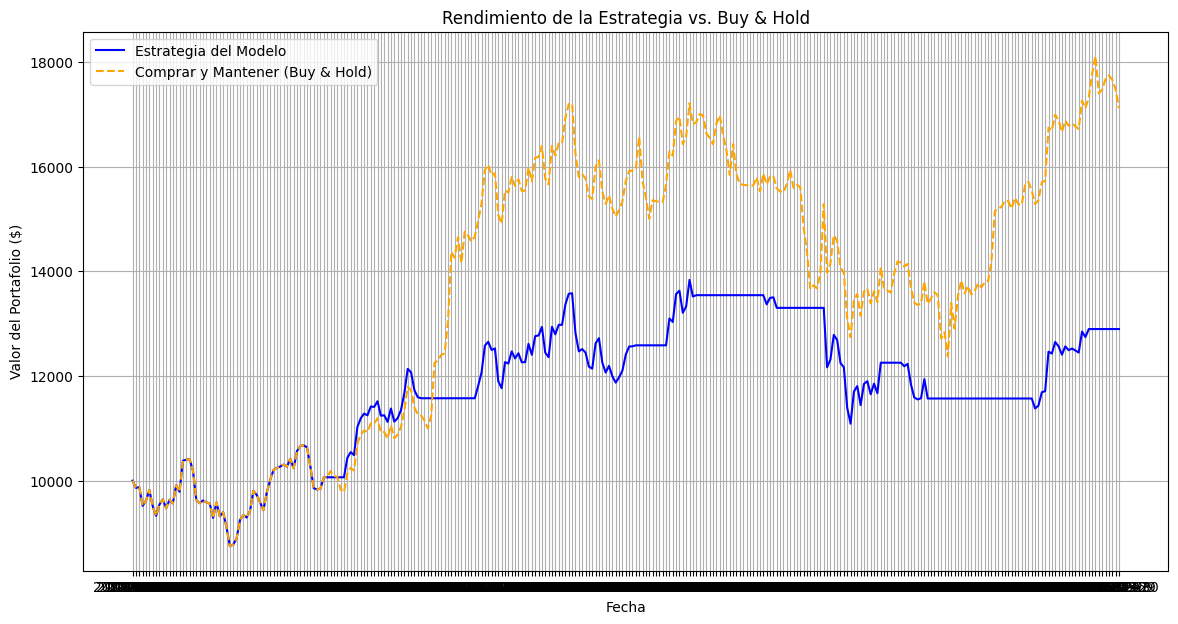

In [17]:
import matplotlib.pyplot as plt

# --- Preparación de Datos para Backtesting ---


# 2. Crear un DataFrame para el backtest
# Usamos una copia del test_set original que contiene precios y fechas
backtest_df = test_set.copy()
backtest_df['signal'] = y_pred_test

# La columna de precio que usaremos es la del día más reciente en la ventana deslizante
# Basado en tu notebook dataCleaning.ipynb, esta columna debería existir. 
# Si el nombre es diferente, ajústalo aquí.
price_col = [col for col in test_set.columns if 'open_d' in col][-1]


# --- Simulación de Backtesting ---

initial_capital = 10000.0
cash = initial_capital
position = 0.0  # Unidades de BTC
portfolio_values = []

for i, row in backtest_df.iterrows():
    price = row[price_col]
    signal = row['signal']
    
    # Lógica de trading
    if signal == 1 and cash > 0:  # Señal de compra
        position = cash / price
        cash = 0.0
    elif signal == -1 and position > 0:  # Señal de venta
        cash = position * price
        position = 0.0
    
    # Calcular el valor actual del portafolio
    current_portfolio_value = cash + position * price
    portfolio_values.append(current_portfolio_value)

backtest_df['portfolio_value'] = portfolio_values


# --- Cálculo de Métricas y Visualización ---

# 1. Calcular métricas de rendimiento
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("--- Resultados del Backtesting ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# 2. Visualizar los resultados
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia del Modelo', color='blue')

# Normalizar el precio para comparar con "Buy & Hold"
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()